In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [23]:
# resize images from it's folder
# run this function only inside that image containing directory only
def resize(dirs):
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((50,50), Image.ANTIALIAS)
            imResize.save(f + ' new.jpg', 'JPEG', quality=90)

In [4]:
path = '/home/iamnildas/Downloads/dogs-vs-cats/x_train/'
dirs = os.listdir(path)
resize(dirs)

In [3]:
os.chdir('x_train')

In [4]:
# you must be in the all train images' directory
x_train = []
y_train = np.zeros((5000,1))
for i in range (5000):
    img = random.choice(os.listdir())
    if img.split(".")[-1]=="jpg":
        imgVec = np.array(Image.open(img))
        x_train.append(imgVec)
    if img.split(".")[-3] == "cat":
        y_train[i,0] = 1
x_train = np.array(x_train)

In [5]:
print(x_train.shape)
print(y_train.shape)

(5000, 50, 50, 3)
(5000, 1)


In [8]:
x_train = x_train/255 # standardize the data set

In [6]:
print ('Number of training examples :'+str(x_train.shape[0]))
print ('Dimension of the x_train :'+str(x_train.shape))
print ('Dimension of the y_train :'+ str(y_train.shape))
print ('Resolution of each image :'+ str(x_train[0].shape))

Number of training examples :5000
Dimension of the x_train :(5000, 50, 50, 3)
Dimension of the y_train :(5000, 1)
Resolution of each image :(50, 50, 3)


In [7]:
# Reshaping x_train (flattenning)
x_train_new = x_train.reshape(x_train.shape[0],-1).T
print ('Dimension of the x_train_new :'+str(x_train_new.shape))
y_train_new = y_train.T
print('Dimension of the y_train_new :'+str(y_train_new.shape))

Dimension of the x_train_new :(7500, 5000)
Dimension of the y_train_new :(1, 5000)


In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(x_train_new.T , y_train_new.T, test_size = 0.25, random_state =42)
print ("X_train shape :"+str(X_train.shape))
print ("Y_train shape :"+str(Y_train.shape))
print ("X_test shape :"+str(X_test.shape))
print ("Y_test shape :"+str(Y_test.shape))

X_train shape :(3750, 7500)
Y_train shape :(3750, 1)
X_test shape :(1250, 7500)
Y_test shape :(1250, 1)


In [9]:
X_train_new = X_train.T
Y_train_new = Y_train.T
X_test_new = X_test.T
Y_test_new = Y_test.T

In [10]:
def sigmoid(x):
  s = 1/(1+np.exp(-x))
  return s
def sigmoid_derivative(x):
  s = sigmoid(x)
  ds = s*(1-s)
  return ds

In [17]:
def image2vector(image):
  v = image.reshape((image.shape[0]*image.shape[1]*image.shape[2]),1)
  return v
def normalize_rows(x):
  x_norm = np.linalg.norm(x,ord=2,axis=1,keepdims=True)
  x=x/x_norm
  return x

In [11]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

The two formulas : 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [19]:
def propagate(w, b, X, Y):
    
    m = X.shape[1]
    
    # Forward propagation
    
    A = sigmoid(np.dot(w.T,X)+b)
    cost = -np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))/m 
    
    # Back propagation
    
    dw = np.dot(X,(A-Y).T)/m
    db = np.sum(A-Y)/m
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [53]:
# Optimize the model to pick the correct value of w and b using propagate()

def optimization(w, b, X, Y, num_of_iterations, learning_rate, print_cost=False):
    
    costs = []
    
    for i in range (num_of_iterations):
        grads , cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i%100==0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    params = {'w': w,
              'b': b}
    grads = {'dw': dw,
            'db' : db}
    return params, grads, costs

In [37]:
# Prediction, learned from w and b from optimization() parameters

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T,X)+b) 
    for i in range(A.shape[1]):
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1 
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [70]:
def LogisticRegression(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimization(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = True)

    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [74]:
d = LogisticRegression(X_train_new, Y_train_new,X_test_new,Y_test_new, num_iterations=10000, learning_rate=0.001, print_cost =True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.682363
Cost after iteration 200: 0.677104
Cost after iteration 300: 0.673326
Cost after iteration 400: 0.670297
Cost after iteration 500: 0.667732
Cost after iteration 600: 0.665482
Cost after iteration 700: 0.663464
Cost after iteration 800: 0.661623
Cost after iteration 900: 0.659925
Cost after iteration 1000: 0.658345
Cost after iteration 1100: 0.656865
Cost after iteration 1200: 0.655471
Cost after iteration 1300: 0.654152
Cost after iteration 1400: 0.652899
Cost after iteration 1500: 0.651704
Cost after iteration 1600: 0.650561
Cost after iteration 1700: 0.649464
Cost after iteration 1800: 0.648410
Cost after iteration 1900: 0.647394
Cost after iteration 2000: 0.646412
Cost after iteration 2100: 0.645462
Cost after iteration 2200: 0.644541
Cost after iteration 2300: 0.643647
Cost after iteration 2400: 0.642777
Cost after iteration 2500: 0.641930
Cost after iteration 2600: 0.641104
Cost after iteration 2700: 0.640297
Cost

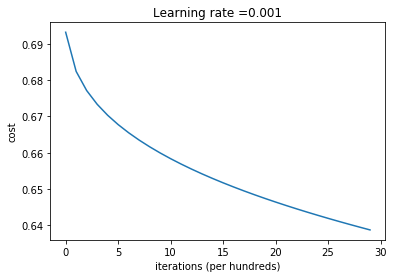

In [72]:
# Plotting the learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
Cost after iteration 0: 0.693147
Cost after iteration 100: 1.667252
Cost after iteration 200: 1.603602
Cost after iteration 300: 1.562083
Cost after iteration 400: 1.531468
Cost after iteration 500: 1.506929
Cost after iteration 600: 1.486024
Cost after iteration 700: 1.467645
Cost after iteration 800: 1.451220
Cost after iteration 900: 1.436377
Cost after iteration 1000: 1.422836
Cost after iteration 1100: 1.410368
Cost after iteration 1200: 1.398790
Cost after iteration 1300: 1.387953
Cost after iteration 1400: 1.377737
train accuracy: 52.906666666666666 %
test accuracy: 52.08 %

-------------------------------------------------------

learning rate is: 0.001
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.682363
Cost after iteration 200: 0.677104
Cost after iteration 300: 0.673326
Cost after iteration 400: 0.670297
Cost after iteration 500: 0.667732
Cost after iteration 600: 0.665482
Cost after iteration 700: 0.663464
Cost after iteration 800: 0.6

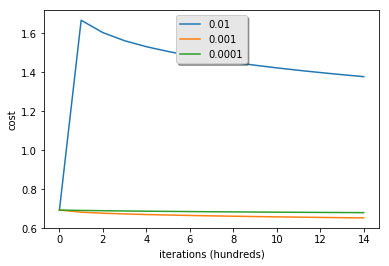

In [73]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = LogisticRegression(X_train_new, Y_train_new,X_test_new,Y_test_new, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()